In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from stable_baselines3 import PPO, A2C
from stable_baselines3.common.callbacks import EvalCallback, CallbackList
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

from sustaingym.envs.evcharging import EVChargingEnv, GMMsTraceGenerator, RealTraceGenerator
from sustaingym.algorithms.evcharging.base_algorithm import GreedyAlgorithm, RandomAlgorithm, RLAlgorithm, MPC


# Analyze Baselines

In [3]:
# Read results from file
from collections import defaultdict
from datetime import datetime
import os
import pickle

import numpy as np

from sustaingym.envs.evcharging.utils import DATE_FORMAT

periods = {'summer2019': 'summer 2019',
           'fall2019': 'fall 2019',
           'spring2020': 'spring 2020',
           'summer2021': 'summer 2021'
}

algorithms = {'ga2': 'greedy',
              'ra2': 'random',
              'mpc1': 'mpc1',
              'mpc2': 'mpc2',
              'mpc6': 'mpc6',
              'mpc12': 'mpc12',
              'mpc36': 'mpc36'
}

baselines = defaultdict(dict)

for lbl in algorithms:
    for season in periods:
        baselines_path = os.path.join(os.getcwd(), 'logs/baselines')
        save_path = os.path.join(baselines_path, lbl, season)
        with open(os.path.join(save_path, 'test_results.pkl'), 'rb') as f:
            results = pickle.load(f)  # 'rewards', 'breakdown'
            rewards, breakdown = results['rewards'], results['breakdown']
        baselines[season][lbl] = results

Rewards from summer2019
greedy: 7.38 +/- 4.11
random: 6.13 +/- 3.69
mpc1: 7.41 +/- 4.12
mpc2: 7.47 +/- 4.15
mpc6: 7.46 +/- 4.16
mpc12: 7.33 +/- 4.17
mpc36: 6.62 +/- 4.17
Rewards from fall2019
greedy: 6.92 +/- 4.28
random: 5.43 +/- 3.52
mpc1: 6.95 +/- 4.30
mpc2: 7.00 +/- 4.34
mpc6: 7.00 +/- 4.34
mpc12: 6.92 +/- 4.32
mpc36: 6.31 +/- 4.11
Rewards from spring2020
greedy: 2.81 +/- 4.46
random: 2.27 +/- 3.70
mpc1: 2.82 +/- 4.47
mpc2: 2.84 +/- 4.51
mpc6: 2.84 +/- 4.50
mpc12: 2.80 +/- 4.46
mpc36: 2.64 +/- 4.24
Rewards from summer2021
greedy: 2.18 +/- 1.45
random: 1.59 +/- 1.05
mpc1: 2.19 +/- 1.46
mpc2: 2.19 +/- 1.46
mpc6: 2.19 +/- 1.46
mpc12: 2.16 +/- 1.46
mpc36: 1.97 +/- 1.38


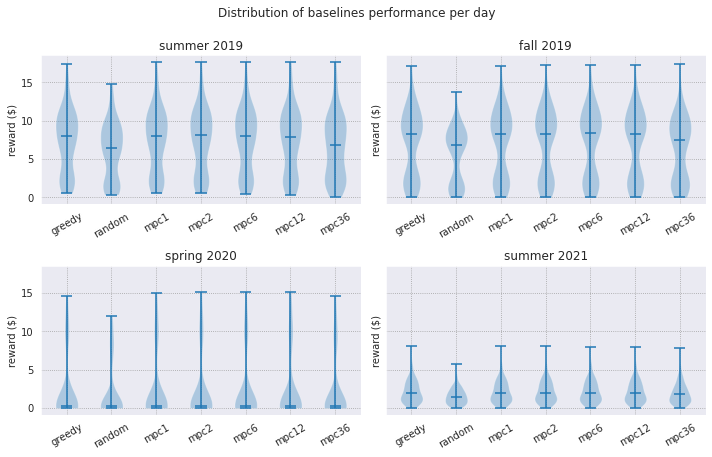

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10, 6))
for i, period in enumerate(periods):
    print(f'Rewards from {period}')
    for lbl in algorithms:
        rews = baselines[period][lbl]['rewards']
        print(f'{algorithms[lbl]}: {np.mean(rews):.2f} +/- {np.std(rews):.2f}')
    row, col = i // 2, i % 2
    data = [baselines[period][lbl]['rewards'] for lbl in algorithms]
    ax[row][col].violinplot(data, showmedians=True)
    ax[row][col].set_ylabel('reward ($)')
    ax[row][col].set_title(periods[period])
    x = np.arange(1, 1 + len(algorithms))  # the label locations
    ax[row][col].set_xticks(x, algorithms.values(), rotation=30)
fig.tight_layout()
fig.suptitle('Distribution of baselines performance per day', y=1.05)

# plt.savefig('algo_comp.png', dpi=300)
plt.show()

In [7]:
baselines[period][lbl]['breakdown']

{'profit': 326.5596786740921,
 'carbon_cost': 84.31043593645347,
 'excess_charge': 0.0}

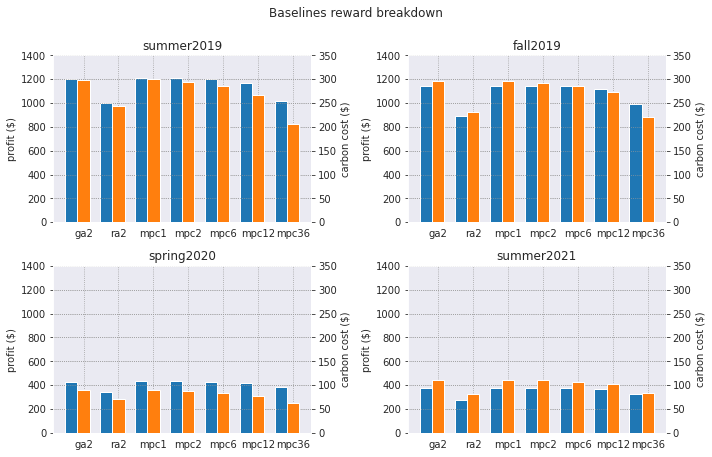

In [31]:
x = np.arange(len(algorithms))  # the label locations
width = 0.35 * 2 / 2  # the width of the bars

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
for i, period in enumerate(periods):
    bdowns = {'profit': [], 'carbon_cost': [], 'excess_charge': []}
    for lbl in algorithms:
        breakdown = baselines[period][lbl]['breakdown']
        for comp in bdowns:
            bdowns[comp].append(breakdown[comp])

    row, col = i // 2, i % 2
    ax1 = ax[row][col]
    ax2 = ax1.twinx()

    rects1 = ax1.bar(x - width, bdowns['profit'], width, label='profit', color='tab:blue')
    rects2 = ax2.bar(x, bdowns['carbon_cost'], width, label='carbon_cost', color='tab:orange')
    # rects3 = ax1.bar(x + width, bdowns['excess_charge'], width, label='excess_charge')  # 0

    ax1.set_ylim(0, 1400)
    ax2.set_ylim(0, 350)
    ax1.set_ylabel('profit ($)')
    ax2.set_ylabel('carbon cost ($)')
    ax1.set_title(f'{period}')
    ax1.set_xticks(x, algorithms)

fig.tight_layout()
fig.suptitle('Baselines reward breakdown', y=1.05)

# plt.savefig('algo_comp.png', dpi=300)
plt.show()

# Analyze Training Curve

In [5]:
groups = {
    ('summer2019', 'ppo', 'discrete'): [101, 102, 103],
    ('spring2020', 'ppo', 'discrete'): [111, 112, 113],
    ('summer2021', 'ppo', 'discrete'): [121, 122, 123],
    ('summer2019', 'ppo', 'continuous'): [151, 152, 153],
    ('spring2020', 'ppo', 'continuous'): [161, 162, 163],
    ('summer2021', 'ppo', 'continuous'): [171, 172, 173],
    ('summer2019', 'a2c', 'discrete'): [201, 202, 203],
    ('spring2020', 'a2c', 'discrete'): [211, 212, 213],
    ('summer2021', 'a2c', 'discrete'): [221, 222, 223],
    ('summer2019', 'a2c', 'continuous'): [251, 252, 253],
    ('spring2020', 'a2c', 'continuous'): [261, 262, 263],
    ('summer2021', 'a2c', 'continuous'): [271, 272, 273],
}


experiment_periods = ['summer2019', 'spring2020', 'summer2021']

# find best trial run in group
for group in groups:
    best_trial, best_reward = 0, -10000
    for trial in groups[group]:
        evals = np.load(f'logs/{group[1]}/exp_{trial}/evaluations.npz')
        res = np.mean(evals['results'], axis=1)
        if res[-1] > best_reward:
            best_trial, best_reward = trial, res[-1]
        timesteps = evals['timesteps']
    groups[group] = best_trial

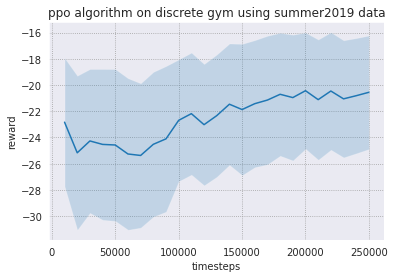

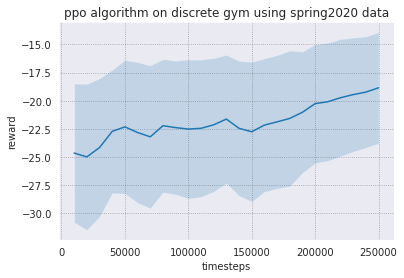

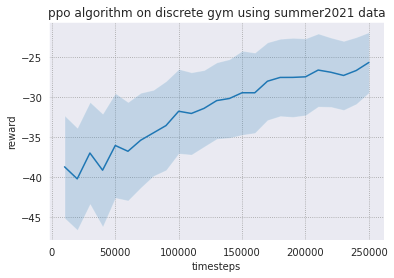

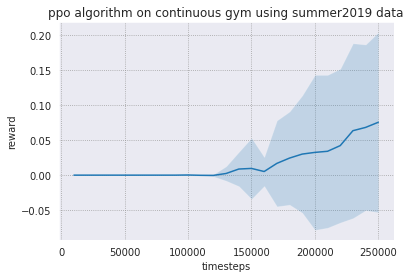

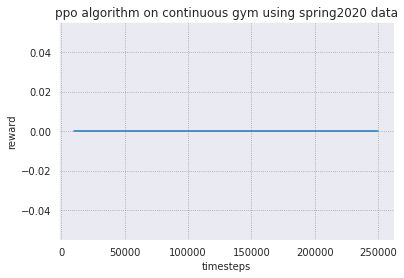

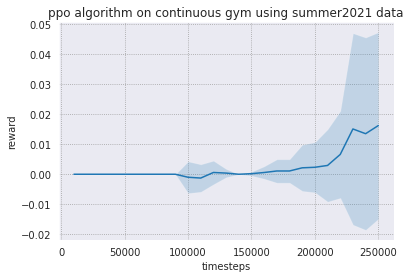

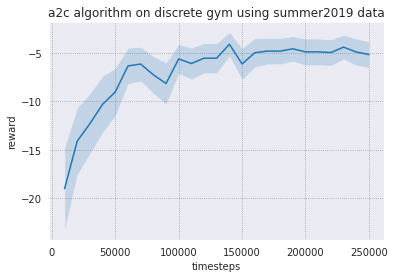

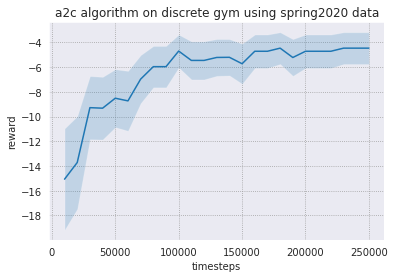

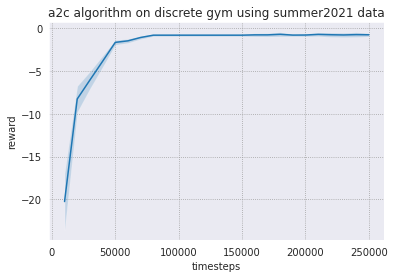

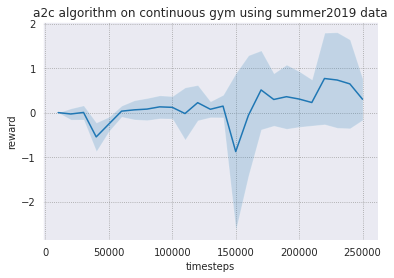

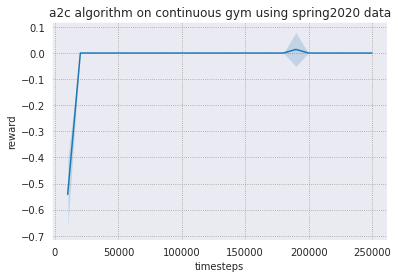

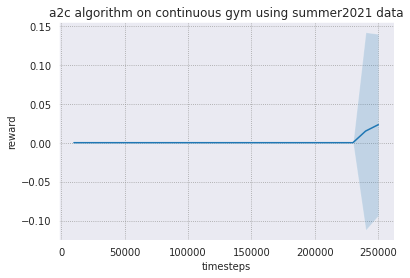

In [6]:
def reward_curve(group):
    # reward curve w/o action projection on 2-week sample in period
    evals = np.load(f'logs/{group[1]}/exp_{groups[group]}/evaluations.npz')
    timesteps, results = evals['timesteps'], evals['results']
    y, error = np.mean(results, axis=1), np.std(results, axis=1)

    plt.plot(timesteps, y)
    plt.fill_between(timesteps, y-error, y+error, alpha=0.2)
    plt.title(f'{group[1]} algorithm on {group[2]} gym using {group[0]} data')
    plt.xlabel('timesteps')
    plt.ylabel('reward')
    plt.show()

for group in groups:
    reward_curve(group)

# Analyze RL Performance on Test Periods

In [84]:
# Line plot of performance over 123 days comparing ppo, a2c, greedy, and mpc6

def retrieve_test_results(rl_alg, exp, season, projected=True):
    if projected:
        eval_type = 'raw'
    else:
        eval_type = 'projection'
    print(eval_type)
    res = f'logs/{rl_alg}/exp_{exp}/{eval_type}/{season}/test_results.pkl'
    with open(res, 'rb') as f:
        return pickle.load(f)

def plot_performance(train_season, action_type, test_season, projected=True):
    lbls = {'ra2': 'random', 'ga2': 'greedy', 'mpc6': 'mpc6'}
    rewards = {k: (0, 0) for k, v in lbls.items()}
    for baseline in lbls:
        rewards[baseline] = np.array(baselines[test_season][baseline]['rewards'])

    for rl_alg in ['ppo', 'a2c']:
        lbls[rl_alg] = rl_alg
        group = (train_season, rl_alg, action_type)
        results = retrieve_test_results(rl_alg, groups[group], test_season, projected)
        rewards[rl_alg] = np.array(results['rewards'])

    data = [rewards[lbl] for lbl in lbls]

    xlabels = lbls.values()
    x_pos = np.arange(1, 1 + len(lbls))
    plt.xticks(x_pos, xlabels)
    plt.violinplot(data, showmedians=True)    
    plt.tight_layout()
    plt.show()


raw
raw


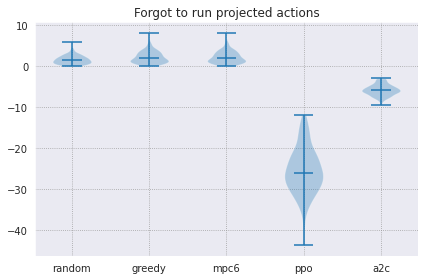

In [86]:
plt.title('Forgot to run projected actions')
plot_performance('summer2019', 'discrete', 'summer2021')